### Importing Dependencies 

In [1]:
import numpy as np
import gymnasium as gym
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout
import matplotlib.pyplot as plt
import random
import copy

from stable_baselines3.common.evaluation import evaluate_policy

# for Behaoivior cloning 
from imitation.algorithms import bc

### Creating the Environment 

In [2]:
env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(),
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],
)

### Creating the Expert 

In [3]:
expert = load_policy(
    "ppo-huggingface",
    organization="HumanCompatibleAI",
    env_name="seals/CartPole-v0",
    venv=env,
)

c:\Users\kobbi\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\kobbi\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\kobbi\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


### Generating data for the training ( the transactions )

In [4]:
rng = np.random.default_rng() 

rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)

In [5]:
def get_transitions(rollouts, n):
    # n number of episodes used for the training  

    transitions = rollout.flatten_trajectories(rollouts[:n])
    return transitions

### Generation the corrupted data

In [18]:
def toggl_acts(rollouts, u):
    l =  len(rollouts)
    
    for i in range(l) :
        k = len(rollouts[i].acts)
        nbr_of_act = int(k * u)
        action_to_toggl = random.sample(range(k), nbr_of_act)
        rollouts[i].acts[action_to_toggl] = 1 - rollouts[i].acts[action_to_toggl]

In [19]:
rollouts_0 = copy.deepcopy(rollouts)
rollouts_5 = copy.deepcopy(rollouts)
rollouts_10 = copy.deepcopy(rollouts)
rollouts_20 = copy.deepcopy(rollouts)
rollouts_50 = copy.deepcopy(rollouts)

toggl_acts(rollouts_5, 0.05)
toggl_acts(rollouts_10, 0.1)
toggl_acts(rollouts_20, 0.2)
toggl_acts(rollouts_50, 0.5)

In [24]:
rollouts_50[-1].acts - rollouts_0[-1].acts

array([ 0,  1, -1,  0,  1,  0,  1, -1,  1,  1,  0, -1,  0, -1,  1,  1, -1,
        0, -1,  0,  0,  1, -1,  0, -1,  1,  0,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  1, -1,  1,  0,  1, -1,  0,  0, -1,  0,  0,  1, -1,  1,  0,
       -1, -1,  1,  0,  0,  1, -1,  0, -1,  0, -1,  1, -1,  0, -1,  1, -1,
        1,  0,  0, -1,  1, -1,  1,  0,  0, -1,  1,  1,  0,  1,  0,  0,  0,
        0,  1,  1,  0, -1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0, -1,  1, -1, -1,  1, -1,  0,  1,  0, -1,  0,  0, -1,  0,  1,  0,
       -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0,  0, -1,  0,  0, -1,
        1,  0,  0,  0,  1,  1, -1, -1,  0,  0,  0, -1,  0,  0,  1, -1,  0,
        0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  1, -1,  1,  0,  0,  1,  0,
        0, -1,  1,  0,  1, -1,  1,  0,  1, -1,  1,  0,  0, -1,  1,  1, -1,
        0,  0, -1,  0,  1, -1,  0, -1,  1, -1,  1, -1, -1,  0,  0,  0,  0,
       -1,  0, -1,  0, -1

### Defining the trainer (policy: ActorCriticPolicy)

In [21]:
def create_trainer(env, transitions):
    return bc.BC(
        observation_space=env.observation_space,
        action_space=env.action_space,
        demonstrations=transitions,
        rng=rng,
        )

In [22]:
bc_trainer = {0 : create_trainer(env, get_transitions(rollouts_0, -1)),
              5 : create_trainer(env, get_transitions(rollouts_5, -1)),
              10 : create_trainer(env, get_transitions(rollouts_10, -1)),
              20 : create_trainer(env, get_transitions(rollouts_20, -1)),
              50 : create_trainer(env, get_transitions(rollouts_50, -1))
}
              

In [23]:
rewards = []

bc_trainer[50].train( 
    n_epochs=10, 
    progress_bar= False, 
    on_epoch_end= lambda : rewards.append(evaluate_policy(bc_trainer[50].policy, env, 1)[0]),
    log_interval=10000
    )

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------


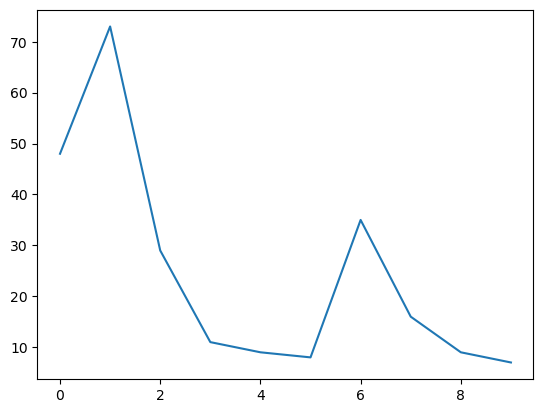

In [25]:
plt.plot(rewards)

# DAgger

In [27]:
import tempfile
from dagger import DAggerTrainer

In [29]:
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    print(tmpdir)
    dagger_trainer = DAggerTrainer(
        venv=env,
        scratch_dir=tmpdir,
        bc_trainer=bc_trainer[0],
        rng=np.random.default_rng(),
    )

    dagger_trainer.train(2000)


C:\Users\kobbi\AppData\Local\Temp\dagger_example_pocogifs


AttributeError: 'DAggerTrainer' object has no attribute 'train'